# Imports

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
%matplotlib inline 
#  !pip3 install mpld3
# import mpld3
#pld3.enable_notebook() causes plotting to not work???

from scipy.integrate import odeint
# !pip3 install lmfit
import lmfit
from lmfit.lineshapes import gaussian, lorentzian, exponential

from time import time
import warnings
warnings.filterwarnings('ignore')
# JSM added
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import sys

In [3]:
from Cluster import * 

Getting data:
getting JHU data...
expanding JHU data : to new (daily), 7-day rolling (smoothed), reporting glitch (corrected) and combined
expansion done.
number of countries listed 274
done with JHU data (covid_ts dictionary keys: confirmed, deaths, recovered).  Got  274 countries (countries_jhu).
getting owid data...
expanding OWID data : to new (daily), 7-day rolling (smoothed), reporting glitch (corrected) and combined
done with OWID data (covid_owid_ts dictionary see .keys()) . Got 212 countries (countries_owid)
WHO acute file found dictionary acute_who
ICU file found dictionary icus_2012
---------------------------------
Done with data.
---------------------------------
Constructing common synchronized deaths, case and testing data...
database JHU correct active True
done.
doing piecwise linear fits to testing data ...
done.
making cases with nonlinear testing adjustment...
done.
to change the nonlinear correction function, call make_cases_adj_nonlin(K), K=2 by default
----------

In [4]:
from model_fits import *  # including ModelFit class definition.

loading data.py...
done with data.py.
making the models...
SEI3R
SC3EI3R
SC3UEI3R
done with the models.


In [5]:
# eliminate countries with no population data (needed for normalizing death stats for fits)

#for country in countries:
#    if population_owid[country][0] == 0:
#        print(country)
        
countries = [cc for cc in countries_common if population_owid[cc][-2] > 0]
print(len(countries),'countries with population data')
countries_zp = [cc for cc in countries_common if population_owid[cc][-2] == 0]
print('common countries without population data',countries_zp)
cluster_countries = [c for c in clusdata_all['deaths']]
print(len(cluster_countries),'cluster countries')


186 countries with population data
common countries without population data []
67 cluster countries


In [6]:
[x for x in covid_ts]

['confirmed',
 'deaths',
 'recovered',
 'new_deaths',
 'new_deaths_smoothed',
 'deaths_smoothed',
 'new_deaths_corrected',
 'new_deaths_corrected_smoothed',
 'deaths_corrected_smoothed',
 'new_confirmed',
 'new_confirmed_smoothed',
 'confirmed_smoothed',
 'new_confirmed_corrected',
 'new_confirmed_corrected_smoothed',
 'confirmed_corrected_smoothed',
 'new_recovered',
 'new_recovered_smoothed',
 'recovered_smoothed',
 'new_recovered_corrected',
 'new_recovered_corrected_smoothed',
 'recovered_corrected_smoothed']

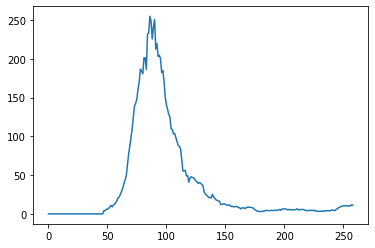

In [7]:
plt.plot(covid_ts['new_deaths_corrected_smoothed'][('Germany','')])

# Curve Fitting Example

We want to fit the following curve:

In [8]:
def exponential_growth(x,A,k):
    return A*np.exp(x*k)

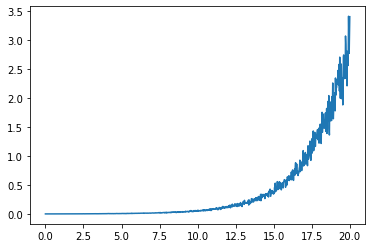

In [9]:
np.random.seed(42)
x = np.linspace(0, 20.0, 1001)

data = (exponential_growth(x, 0.001, 0.4) * (1.0 + np.random.normal(scale=0.1, size=x.size)))  # exponential distr. with some noise
plt.plot(x, data);

So we define a function that takes x as the first argument, and then the parameters to be fitted (a, b, c)

In [10]:
def f(x, a, b):
    return exponential_growth(x, a, b) 

In [11]:
mod = lmfit.Model(f)
# we set the parameters (and some initial parameter guesses)
mod.set_param_hint("a", value=0.02, vary=True)
mod.set_param_hint("b", value=0.5, vary=True)

params = mod.make_params()

In [12]:
result = mod.fit(data, params, method="leastsq", x=x)  # fitting

{'a': 0.0011015708523488322, 'b': 0.3951473987912008}

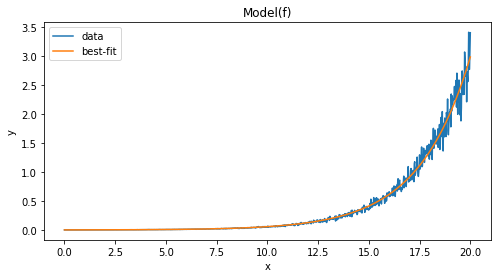

In [13]:
plt.figure(figsize=(8,4))
result.plot_fit(datafmt="-");
result.best_values

In [ ]:
result

# Use `Modelfit.solvefit()` with `lmfit`

In [ ]:
#  for debugging class methods without having to reload all of model_fits.py:
#  file containing only ModelFit class, 
exec(open('ModelFit.py','r').read())

In [45]:
country = 'Germany'
###############################################
## do the fit
MyModel = ModelFit('SC3EI3R',country=country,run_id="_test1",data_src='owid')

For this run_id, a fresh file:  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Germany_test1.pk


In [46]:
params_init_min_max = {
                   "beta_1": (0.4, 0.3, 0.6,0.001),
                   #"mu": (.05,0.03,0.15,0.001),
                   "c_0": (0.1, 0.05, 1.0,0.001), 
                   "c_1": (0.07, 0.0, 0.1,0.001),
                   #"c_2": (5., 1., 8., 0.01), 
                    "logI_0": (-6.,-9.,-5.,0.001)}
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})

In [47]:
MyModel.params

{'beta_1': 0.4,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'alpha': 0.2,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666669,
 'gamma_3': 0.1,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333333,
 'mu': 0.1,
 'c_0': 0.1,
 'c_1': 0.07,
 'c_2': 10.0,
 'N': 1}

In [72]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
fit_ctrl = {'max_nfev':None,'ftol':0.001,'xtol':0.01,'epsfcn':0.0001} # one can try setting these to improve fit behaviour
#fit_ctrl = {}
# MyModel.fit(params_init_min_max,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['confirmed'],fit_data=['confirmed_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
#MyModel.fit(params_init_min_max,fit_method='differential_evolution',fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)

MyModel.fit(params_init_min_max,fit_method='leastsq',fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)

# MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])

elapsed time =  1.6035618782043457
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 249
    # variables        = 4
    chi-square         = 2.5101e-08
    reduced chi-square = 1.0245e-10
    Akaike info crit   = -5723.43406
    Bayesian info crit = -5709.36424
[[Variables]]
    beta_1:  0.46344674 +/- 7.3015e-04 (0.16%) (init = 0.4)
    c_0:     0.23279829 +/- 0.00113330 (0.49%) (init = 0.1)
    c_1:     0.00473156 +/- 4.6215e-05 (0.98%) (init = 0.07)
    logI_0: -7.61024803 +/- 0.00856671 (0.11%) (init = -6)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta_1, logI_0) = -0.978
    C(beta_1, c_0)    = -0.975
    C(c_0, logI_0)    =  0.945
    C(c_0, c_1)       = -0.691
    C(beta_1, c_1)    =  0.524
    C(c_1, logI_0)    = -0.489


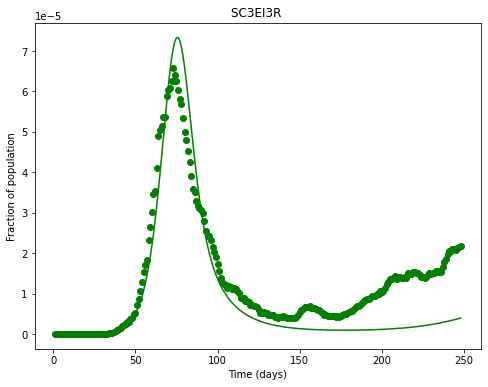

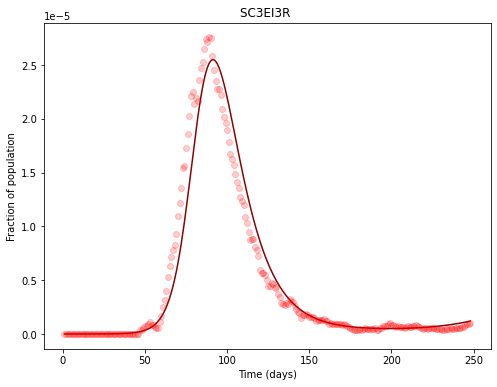

In [73]:
MyModel.solveplot(['confirmed'],datasets=['confirmed_corrected_smoothed'])
MyModel.solveplot(['deaths'],datasets=['deaths_corrected_smoothed'])

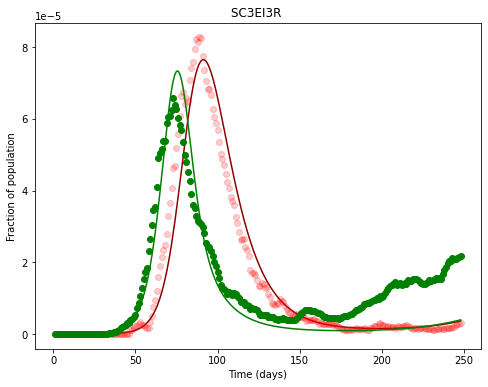

In [74]:
MyModel.solveplot(['deaths','confirmed'],datasets=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],mag={'deaths':30.})

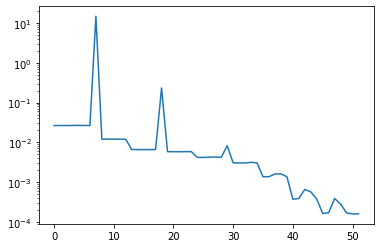

In [75]:
# this line requires fit with diag=True
plt.semilogy(MyModel.residall);

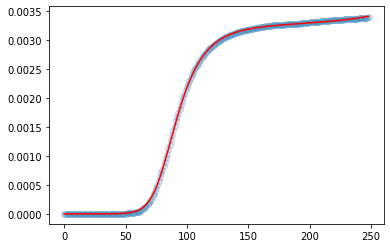

In [76]:
foo = MyModel.solve4fit('deaths','deaths_corrected_smoothed')

plt.plot(foo['deaths']['data'],'o',alpha=0.2);
plt.plot(foo['deaths']['soln'],color='red');

In [77]:
# this cell require fit to be run with diag=True
pars = [x for x in MyModel.paramall[0]]
pars

['beta_1', 'c_0', 'c_1', 'logI_0']

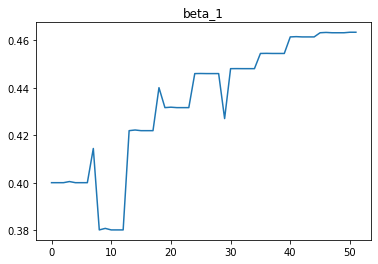

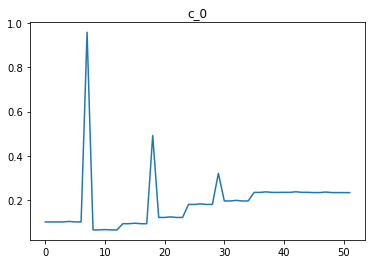

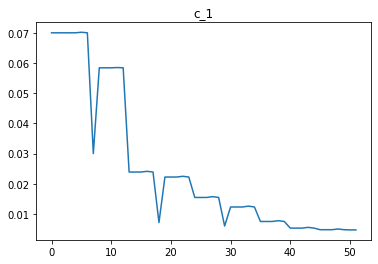

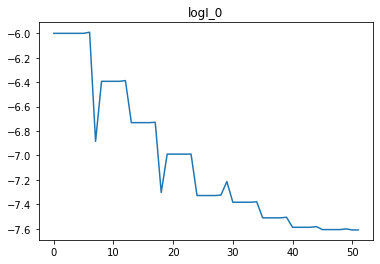

In [78]:
for pp in pars:
    pt = [x[pp].value for x in MyModel.paramall]
    plt.plot(pt)
    plt.title(pp)
    plt.show()

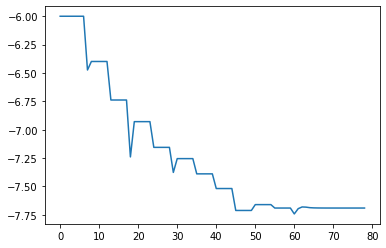

In [24]:
p0 = [x[pars[-1]] for x in MyModel.paramall]
plt.plot(p0);

In [25]:
# outfit.params
MyModel.params

{'beta_1': 0.46292850591912516,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'alpha': 0.2,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666669,
 'gamma_3': 0.1,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333333,
 'mu': 0.1,
 'c_0': 0.21513165119951644,
 'c_1': 0.009207999681988228,
 'c_2': 10.0,
 'N': 1}

## Trying different fitting methods...

see [lmfit documentation](https://lmfit.github.io/lmfit-py/fitting.html) on fitting methods for the list.

In this section I am using the same basic template to repeat the basic fitting operation with different fitting methods.

All seem to work.  Some comments:
* some (e.g. leastsq, differential_evolution) seem to hop all over the place, giving wildly varying residual socre and param convergence.
* some (powell, cobyla)seem to converge fast at beginning, with a slow tail (view residual plot with semilog)
* initially chose nelder, because of consistent gradual convergence.
* then switched back to leastsq as it gave fast reliable results after other problems had been resolved

## USA

### fit deaths+confirmed

In [7]:
country = 'United States'
###############################################
## do the fit
MyModel = ModelFit('SC3EI3R',country=country,run_id="_test1",data_src='owid')

For this run_id, a fresh file:  /Users/n/Projects/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_United States_test1.pk


In [8]:
params_init_min_max = {
                   "beta_1": (0.4, 0.3, 0.6,0.001),
                   "mu": (.05,0.03,0.15,0.001),
                   "c_0": (0.1, 0.05, 1.0,0.001), 
                   "c_1": (0.07, 0.0, 0.1,0.001),
                   "c_2": (5., 1., 8., 0.01), 
                    "logI_0": (-6.,-9.,-5.,0.001)}
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})

In [9]:
MyModel.params

{'beta_1': 0.4,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'alpha': 0.2,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666669,
 'gamma_3': 0.1,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333333,
 'mu': 0.05,
 'c_0': 0.1,
 'c_1': 0.07,
 'c_2': 5.0,
 'N': 1}

In [18]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
# fit_ctrl = {'max_nfev':None,'ftol':0.001,'xtol':0.01,'epsfcn':0.0001} # one can try setting these to improve fit behaviour
fit_ctrl = {}
# MyModel.fit(params_init_min_max,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['confirmed'],fit_data=['confirmed_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])

elapsed time =  2.6575779914855957
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 219
    # data points      = 498
    # variables        = 6
    chi-square         = 0.00108715
    reduced chi-square = 2.2097e-06
    Akaike info crit   = -6479.32733
    Bayesian info crit = -6454.06373
[[Variables]]
    beta_1:  0.30001001 +/- 0.01988151 (6.63%) (init = 0.4)
    mu:      0.07116709 +/- 0.00166491 (2.34%) (init = 0.05)
    c_0:     0.10990871 +/- 0.19372618 (176.26%) (init = 0.1)
    c_1:     0.10000000 +/- 8.6581e-06 (0.01%) (init = 0.07)
    c_2:     2.03254009 +/- 0.76705996 (37.74%) (init = 5)
    logI_0: -5.99953328 +/- 0.28557893 (4.76%) (init = -6)
[[Correlations]] (unreported correlations are < 0.100)
    C(c_0, c_2)       =  0.978
    C(beta_1, logI_0) = -0.960
    C(c_0, c_1)       =  0.844
    C(c_1, c_2)       =  0.729
    C(c_1, logI_0)    =  0.511
    C(beta_1, c_2)    =  0.424
    C(beta_1, c_1)    = -0.300
    C(beta_1, c_0)    =  0.234
   

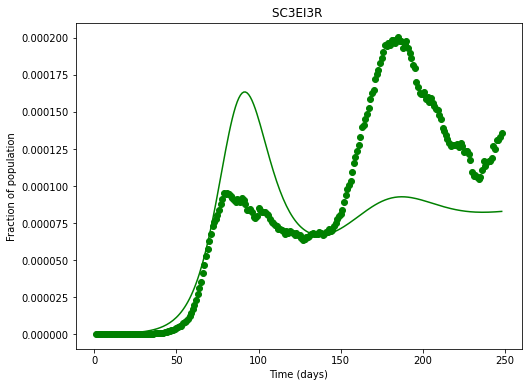

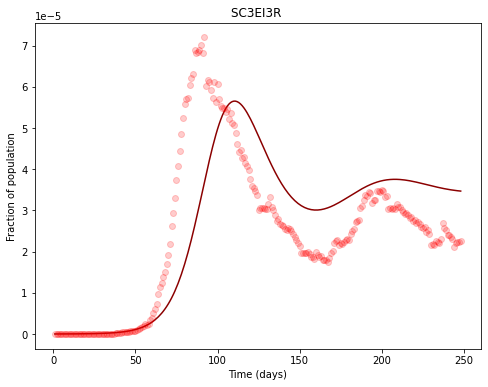

In [19]:
MyModel.solveplot(['confirmed'],datasets=['confirmed_corrected_smoothed'])
MyModel.solveplot(['deaths'],datasets=['deaths_corrected_smoothed'])

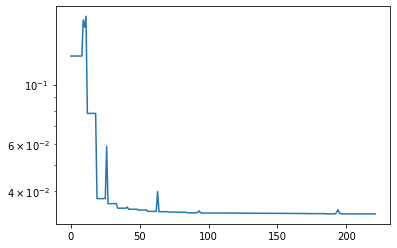

In [20]:
# this line requires fit with diag=True
plt.semilogy(MyModel.residall);

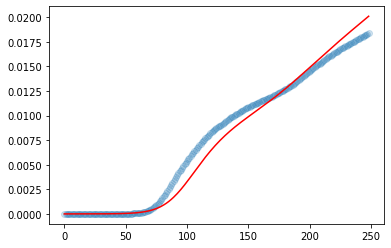

In [21]:
foo = MyModel.solve4fit('deaths','deaths_corrected_smoothed')

plt.plot(foo['deaths']['data'],'o',alpha=0.2);
plt.plot(foo['deaths']['soln'],color='red');

In [22]:
# this cell require fit to be run with diag=True
pars = [x for x in MyModel.paramall[0]]
pars

['beta_1', 'mu', 'c_0', 'c_1', 'c_2', 'logI_0']

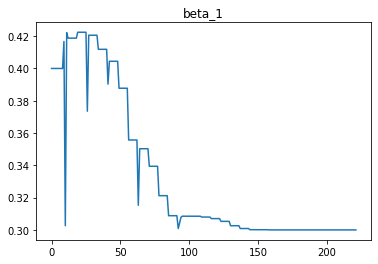

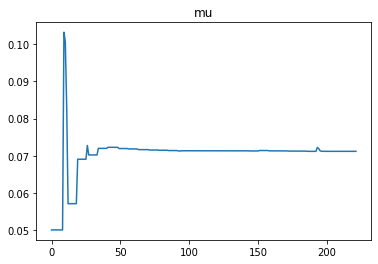

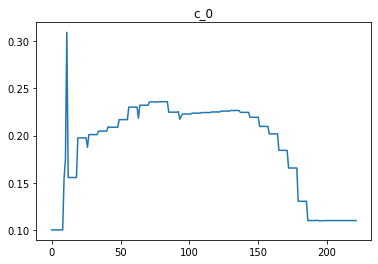

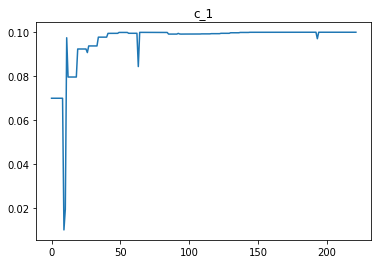

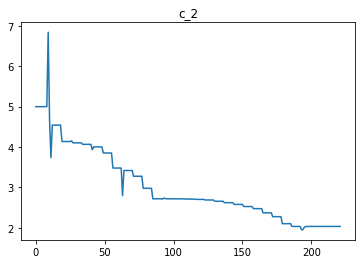

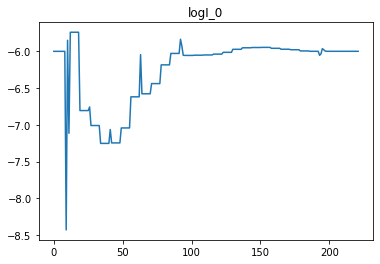

In [23]:
for pp in pars:
    pt = [x[pp].value for x in MyModel.paramall]
    plt.plot(pt)
    plt.title(pp)
    plt.show()

### fit deaths only

In [12]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
# fit_ctrl = {'max_nfev':None,'ftol':0.001,'xtol':0.01,'epsfcn':0.0001} # one can try setting these to improve fit behaviour
fit_ctrl = {}
# MyModel.fit(params_init_min_max,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['confirmed'],fit_data=['confirmed_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
MyModel.fit(params_init_min_max,fit_targets=['deaths'],fit_data=['deaths_corrected_smoothed'],diag=True,report=True,conf_interval=False,fit_kws=fit_ctrl)
# MyModel.fit(params_init_min_max,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])

elapsed time =  2.0527310371398926
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 176
    # data points      = 249
    # variables        = 6
    chi-square         = 5.8163e-06
    reduced chi-square = 2.3935e-08
    Akaike info crit   = -4363.50284
    Bayesian info crit = -4342.39812
[[Variables]]
    beta_1:  0.33523276 +/- 0.01196875 (3.57%) (init = 0.4)
    mu:      0.05647436 +/- 0.02715295 (48.08%) (init = 0.05)
    c_0:     0.25027596 +/- 4.9288e-05 (0.02%) (init = 0.1)
    c_1:     0.04984196 +/- 0.00850260 (17.06%) (init = 0.07)
    c_2:     1.77626365 +/- 0.57513196 (32.38%) (init = 5)
    logI_0: -5.81956182 +/- 0.14448515 (2.48%) (init = -6)
[[Correlations]] (unreported correlations are < 0.100)
    C(mu, c_2)        =  0.981
    C(mu, c_1)        = -0.971
    C(c_1, c_2)       = -0.924
    C(c_2, logI_0)    = -0.861
    C(mu, logI_0)     = -0.753
    C(c_1, logI_0)    =  0.670
    C(beta_1, c_1)    =  0.580
    C(beta_1, mu)     = -0.548
   

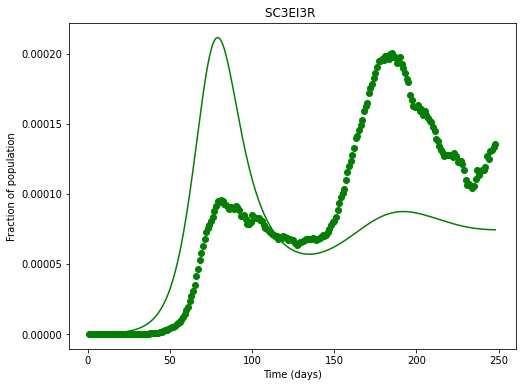

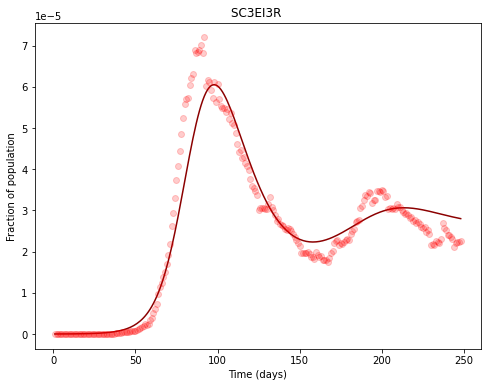

In [13]:
MyModel.solveplot(['confirmed'],datasets=['confirmed_corrected_smoothed'])
MyModel.solveplot(['deaths'],datasets=['deaths_corrected_smoothed'])

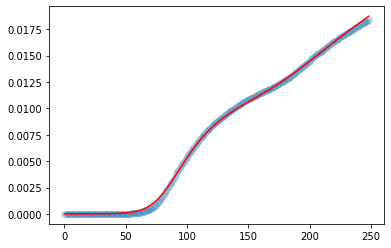

In [15]:
foo = MyModel.solve4fit('deaths','deaths_corrected_smoothed')

plt.plot(foo['deaths']['data'],'o',alpha=0.2);
plt.plot(foo['deaths']['soln'],color='red');

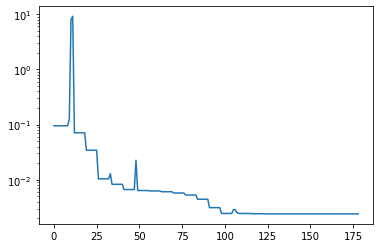

In [14]:
# this line requires fit with diag=True
plt.semilogy(MyModel.residall);

In [16]:
# this cell require fit to be run with diag=True
pars = [x for x in MyModel.paramall[0]]
pars

['beta_1', 'mu', 'c_0', 'c_1', 'c_2', 'logI_0']

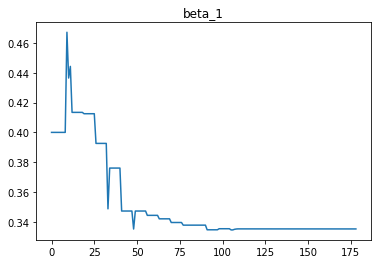

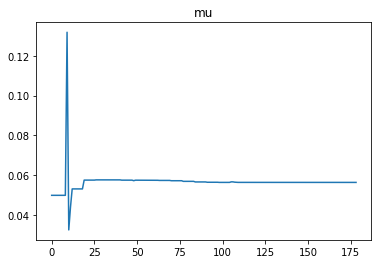

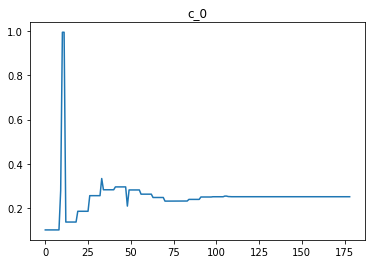

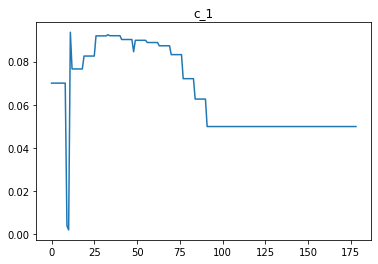

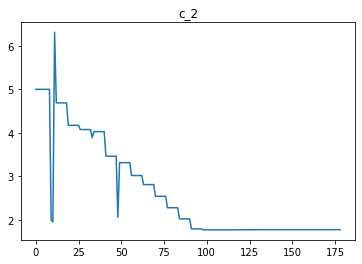

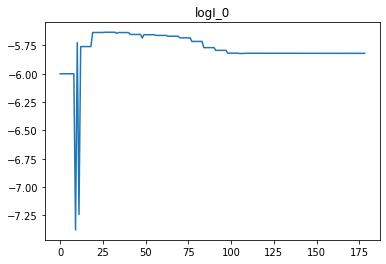

In [17]:
for pp in pars:
    pt = [x[pp].value for x in MyModel.paramall]
    plt.plot(pt)
    plt.title(pp)
    plt.show()

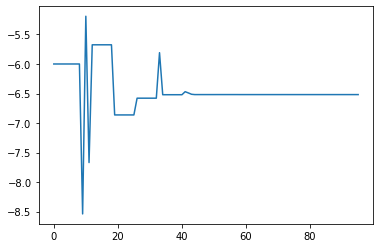

In [35]:
p0 = [x[pars[-1]] for x in MyModel.paramall]
plt.plot(p0);

# ModelFit with lmfit integrated

## SC3EI3R 

### Test on Germany with method Nelder

In [36]:
#  for debugging class methods without having to reload all of model_fits.py:
#  file containing only ModelFit class, 
exec(open('ModelFit.py','r').read())

In [37]:
country = 'Germany'
###############################################
## do the fit
MyModel = ModelFit('SC3EI3R',country=country,run_id="_test2")

For this run_id, a fresh file:  /Users/john/projects/Covid-19/covid-recovery/Notebooks/covid-19-caution/params/SC3EI3R_Germany_test2.pk


In [38]:
params_init_min_max = {"beta_1": (0.2, 0., 2.,0.001),
                   "mu": (.1,0.,.2,0.001),
                   "c_0": (0.1, 0., 1.0,0.001), 
                   "c_1": (0.05, 0.0, 0.5,0.001),
                   "c_2": (2., 0.,20.,0.01), 
                    "logI_0": (-6.,-10.,0.0,0.01)}
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})

In [39]:
MyModel.params

{'beta_1': 0.2,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'alpha': 0.2,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666669,
 'gamma_3': 0.1,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333333,
 'mu': 0.1,
 'c_0': 0.1,
 'c_1': 0.05,
 'c_2': 2.0,
 'N': 1}

In [40]:
# MyModel.fit(params_init_min_max,diag=False) without fit report
MyModel.fit(params_init_min_max,fit_method='nelder',fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],diag=False,report=True)

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 1705
    # data points      = 518
    # variables        = 6
    chi-square         = 1.2539e-05
    reduced chi-square = 2.4490e-08
    Akaike info crit   = -9071.97857
    Bayesian info crit = -9046.47872
[[Variables]]
    beta_1:  0.47145789 +/- 0.00352852 (0.75%) (init = 0.2)
    mu:      0.08377569 +/- 9.5258e-04 (1.14%) (init = 0.1)
    c_0:     0.20553269 +/- 0.01109070 (5.40%) (init = 0.1)
    c_1:     0.00922126 +/- 2.1995e-04 (2.39%) (init = 0.05)
    c_2:     8.94635098 +/- 0.37956377 (4.24%) (init = 2)
    logI_0: -7.76822399 +/- 0.03057998 (0.39%) (init = -6)
[[Correlations]] (unreported correlations are < 0.100)
    C(c_0, c_2)       =  0.911
    C(beta_1, c_2)    =  0.643
    C(beta_1, logI_0) = -0.557
    C(beta_1, c_0)    =  0.349
    C(c_1, c_2)       =  0.265
    C(c_0, logI_0)    =  0.246
    C(beta_1, c_1)    =  0.131
    C(mu, c_0)        = -0.127
    C(c_0, c_1)       =  0.123


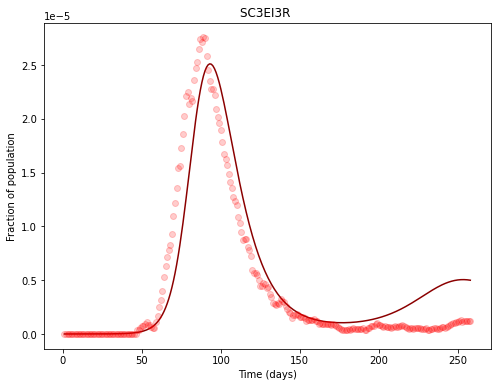

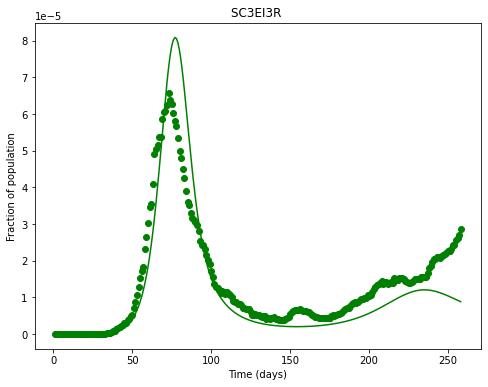

In [41]:
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])
MyModel.solveplot('confirmed',datasets=['confirmed_corrected_smoothed'])

#### slider plot

In [42]:
from IPython.display import display, HTML
from ipywidgets.widgets import interact, interactive, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed
display(HTML("<style>.container { width:100% !important; }</style>"))
style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

In [43]:
params_init_min_max_slider = params_init_min_max.copy()
params_init_min_max_slider = MyModel.transfer_fit_to_params_init(params_init_min_max_slider)

In [44]:
sliderparams = MyModel.allsliderparams(params_init_min_max_slider)
if sliderparams:
    w=interactive(MyModel.slidefitplot,param_class=fixed('ode'),**sliderparams)
    display(w)

interactive(children=(FloatSlider(value=0.4714578906260807, continuous_update=False, description='beta_1', lay…

In [45]:
params_init_min_max_slider = MyModel.transfer_fit_to_params_init(params_init_min_max_slider)

In [46]:
MyModel.prparams()

params:
{'N': 1,
 'alpha': 0.2,
 'beta_1': 0.4714578906260807,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'c_0': 0.20553268860182355,
 'c_1': 0.009221259487916689,
 'c_2': 8.946350975676985,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666669,
 'gamma_3': 0.1,
 'mu': 0.08377569414439347,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333333}
sbparams:
{'CFR': 0.05,
 'DurHosp': 4,
 'DurMildInf': 10,
 'Exposure': 0.4,
 'FracCritical': 0.1,
 'FracMild': 0.7,
 'ICUFrac': 0.001,
 'IncubPeriod': 5,
 'TimeICUDeath': 5,
 'logI_0': -7.44}
pfbarams:
{'FracConfirmedDet': 1.0, 'FracDeathsDet': 1.0}
cbparams:
{'CautionExposure': 0.1,
 'CautionFactor': 0.1,
 'CautionRetention': 60.0,
 'EconomicCostOfCaution': 0.5,
 'EconomicRetention': 60.0,
 'EconomicStriction': 30.0,
 'EconomyRelaxation': 60.0}
dbparams:
{'country': 'Germany', 'data_src': 'owid', 'run_name': 'SC3EI3R'}
initial_values:
(array([9.99999964e-01, 0.00000000e+00, 3.63078055e-08, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+

### Test on USA

In [84]:
country = 'United States'
###############################################
## do the fit
MyModel = ModelFit('SC3EI3R',country=country,run_id="_test2",new=True)

In [94]:
params_init_min_max = {"beta_1": (0.4, 0., 2.,0.001),
                   "mu": (.1,0.,.2,0.001),
                   "c_0": (0.1, 0., 1.0,0.001), 
                   "c_1": (0.05, 0.0, 0.5,0.001),
                   "c_2": (2., 0.,20.,0.01), 
                    "logI_0": (-6.,-10.,0.0,0.01)}
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})

In [95]:
MyModel.params

{'beta_1': 0.4,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'alpha': 0.2,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666669,
 'gamma_3': 0.1,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333333,
 'mu': 0.1,
 'c_0': 0.1,
 'c_1': 0.05,
 'c_2': 2.0,
 'N': 1}

In [90]:
MyModel.fit(params_init_min_max,fit_method='nelder',diag=False) # without fit report
# MyModel.fit(params_init_min_max,fit_method='nelder',fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'],diag=False,report=True)

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 985
    # data points      = 249
    # variables        = 6
    chi-square         = 1.5634e-06
    reduced chi-square = 6.4337e-09
    Akaike info crit   = -4690.64252
    Bayesian info crit = -4669.53781
[[Variables]]
    beta_1:  0.40881192 +/- 0.00201677 (0.49%) (init = 0.2)
    mu:      0.09946810 +/- 5.7886e-04 (0.58%) (init = 0.1)
    c_0:     0.24803900 +/- 0.00164184 (0.66%) (init = 0.1)
    c_1:     0.04361164 +/- 4.0587e-04 (0.93%) (init = 0.05)
    c_2:     3.86044869 +/- 0.03803584 (0.99%) (init = 2)
    logI_0: -6.84335648 +/- 0.02046306 (0.30%) (init = -6)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta_1, logI_0) = -0.955
    C(beta_1, c_2)    =  0.786
    C(c_2, logI_0)    = -0.710
    C(beta_1, c_1)    =  0.546
    C(c_1, c_2)       =  0.516
    C(mu, c_1)        = -0.507
    C(c_0, c_1)       = -0.457
    C(c_1, logI_0)    = -0.403
    C(c_0, logI_0)    =  0.392
    C(b

### comparing initial param values (e.g. beta_1)

Call to match country scan below...

In [185]:
mymethod = 'slsqp'

In [186]:
params_init_min_max = {"beta_1": (0.2, 0.0, 2.0,0.001),
                   "mu": (.1,0.,.2,0.001),
                   "c_0": (0.1, 0., 1.0,0.001), 
                   "c_1": (0.05, 0.0, 0.5,0.001),
                   "c_2": (2., 0.,20.,0.01), 
                    "logI_0": (-6.,-10.,0.0,0.01)}
MyModel = ModelFit('SC3EI3R',country=country,run_id="_scan",new=True) # run_id labels parameter dump files
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})
MyModel.fit(params_init_min_max,fit_method=mymethod,diag=True,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])

elapsed time =  5.892093896865845
[[Fit Statistics]]
    # fitting method   = SLSQP
    # function evals   = 188
    # data points      = 498
    # variables        = 6
    chi-square         = 0.00117839
    reduced chi-square = 2.3951e-06
    Akaike info crit   = -6439.19392
    Bayesian info crit = -6413.93032
##  Warning: uncertainties could not be estimated:
[[Variables]]
    beta_1:  0.29438247 +/-        nan (nan%) (init = 0.2)
    mu:      0.07080937 +/- 0.00167312 (2.36%) (init = 0.1)
    c_0:     0.11321172 +/- 0.06256503 (55.26%) (init = 0.1)
    c_1:     0.05841981 +/- 0.00497374 (8.51%) (init = 0.05)
    c_2:     1.33412124 +/- 0.18923026 (14.18%) (init = 2)
    logI_0: -6.03737888 +/- 0.06391643 (1.06%) (init = -6)
[[Correlations]] (unreported correlations are < 0.100)
    C(c_2, logI_0) =  1.208
    C(c_0, logI_0) =  1.014
    C(c_0, c_2)    =  0.906
    C(c_1, logI_0) =  0.681
    C(c_1, c_2)    =  0.679
    C(c_0, c_1)    =  0.345
    C(mu, c_1)     = -0.115


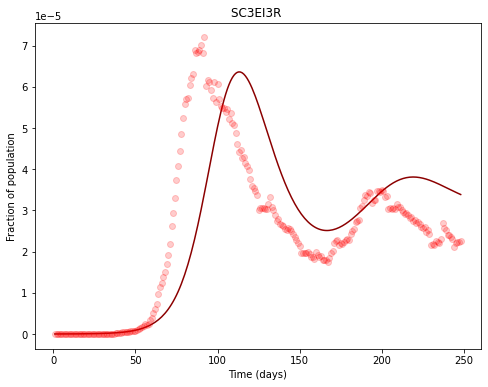

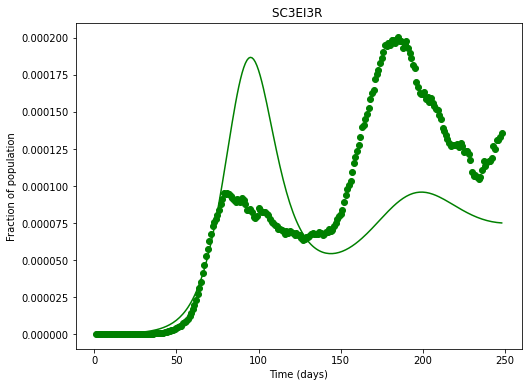

In [187]:
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])
MyModel.solveplot('confirmed',datasets=['confirmed_corrected_smoothed'])

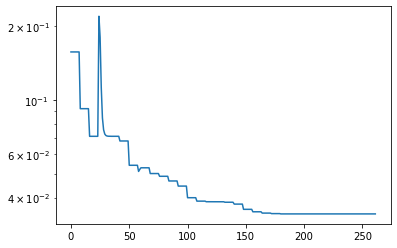

In [188]:
# this line requires fit with diag=True
plt.semilogy(MyModel.residall);

In [189]:
# this cell require fit to be run with diag=True
pars = [x for x in MyModel.paramall[0]]
pars

['beta_1', 'mu', 'c_0', 'c_1', 'c_2', 'logI_0']

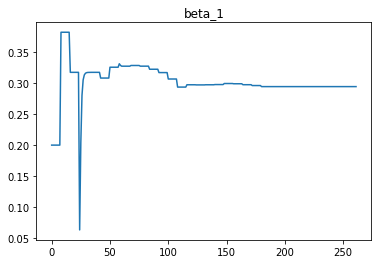

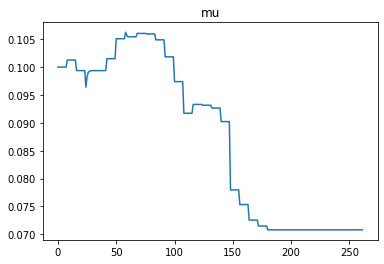

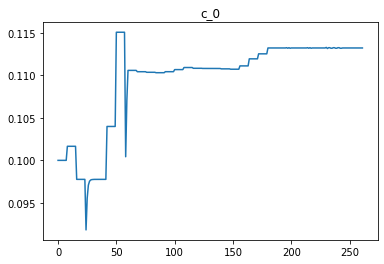

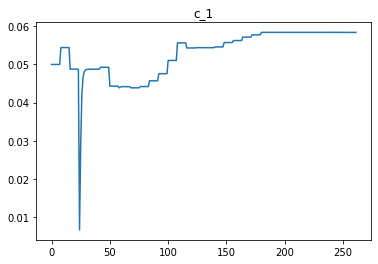

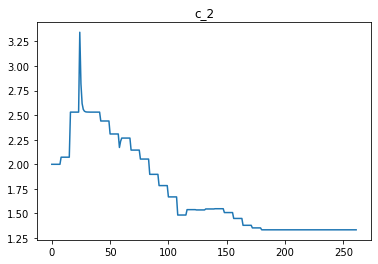

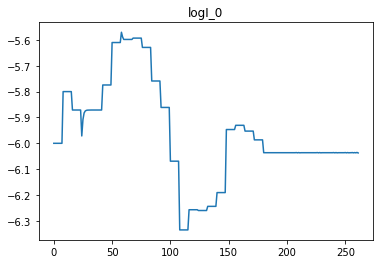

In [190]:
for pp in pars:
    pt = [x[pp].value for x in MyModel.paramall]
    plt.plot(pt)
    plt.title(pp)
    plt.show()

In [191]:
params_init_min_max = {"beta_1": (0.4, 0, 2.0,0.001),
                   "mu": (.1,0.,.2,0.001),
                   "c_0": (0.1, 0., 1.0,0.001), 
                   "c_1": (0.05, 0.0, 0.5,0.001),
                   "c_2": (2., 0.,20.,0.01), 
                    "logI_0": (-6.,-10.,0.0,0.01)}
MyModel = ModelFit('SC3EI3R',country=country,run_id="_scan",new=True) # run_id labels parameter dump files
MyModel.model.parameters = {p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'}
MyModel.params.update({p:params_init_min_max[p][0] for p in params_init_min_max if p != 'logI_0'})
MyModel.fit(params_init_min_max,fit_method=mymethod,diag=True,fit_targets=['deaths','confirmed'],fit_data=['deaths_corrected_smoothed','confirmed_corrected_smoothed'])

elapsed time =  4.08487606048584
[[Fit Statistics]]
    # fitting method   = SLSQP
    # function evals   = 95
    # data points      = 498
    # variables        = 6
    chi-square         = 0.00151583
    reduced chi-square = 3.0810e-06
    Akaike info crit   = -6313.79044
    Bayesian info crit = -6288.52684
##  Warning: uncertainties could not be estimated:
[[Variables]]
    beta_1:  0.32563456 +/- 0.00859312 (2.64%) (init = 0.4)
    mu:      0.09714204 +/- 0.00107330 (1.10%) (init = 0.1)
    c_0:     0.12244695 +/- 0.00862149 (7.04%) (init = 0.1)
    c_1:     0.06702751 +/-        nan (nan%) (init = 0.05)
    c_2:     2.18542609 +/- 0.06363033 (2.91%) (init = 2)
    logI_0: -6.44666463 +/- 0.04564022 (0.71%) (init = -6)
[[Correlations]] (unreported correlations are < 0.100)
    C(c_2, logI_0)    = -1.457
    C(beta_1, c_0)    = -1.308
    C(c_0, c_2)       = -1.229
    C(beta_1, c_2)    =  0.980
    C(beta_1, logI_0) = -0.841
    C(mu, logI_0)     = -0.534
    C(c_0, logI_0)    = 

[[Variables]]
    beta_1:  0.32665845 +/- 0.46153068 (141.29%) (init = 0.2)
    mu:      0.09205437 +/- 0.06980213 (75.83%) (init = 0.1)
    c_0:     0.18519038 +/- 0.21390488 (115.51%) (init = 0.1)
    c_1:     0.16174352 +/- 0.16259196 (100.52%) (init = 0.05)
    c_2:     9.32518629 +/- 6.93746369 (74.39%) (init = 2)
    logI_0: -6.00779344 +/- 2.75916716 (45.93%) (init = -6)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta_1, c_0) = -0.441
    C(beta_1, c_2) =  0.229
    C(c_1, c_2)    =  0.225
    C(c_0, c_1)    =  0.124
    C(beta_1, mu)  = -0.108
    C(mu, c_0)     =  0.107

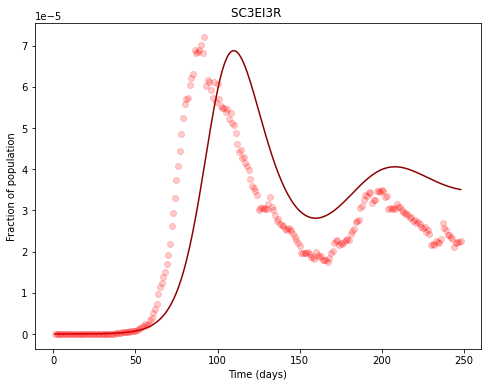

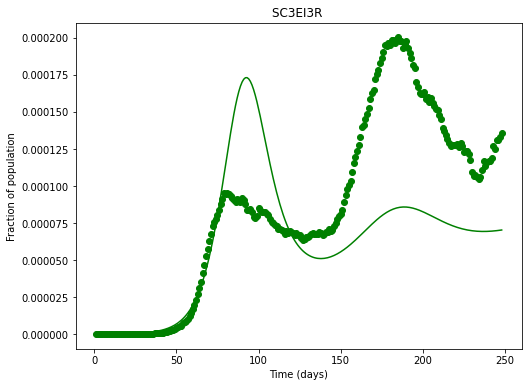

In [192]:
MyModel.solveplot('deaths',datasets=['deaths_corrected_smoothed'])
MyModel.solveplot('confirmed',datasets=['confirmed_corrected_smoothed'])

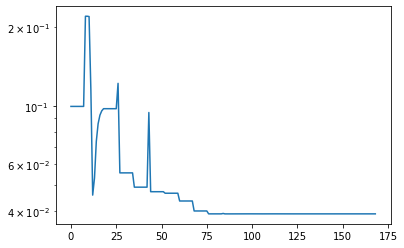

In [193]:
# this line requires fit with diag=True
plt.semilogy(MyModel.residall);

In [168]:
# this cell require fit to be run with diag=True
pars = [x for x in MyModel.paramall[0]]
pars

['beta_1', 'mu', 'c_0', 'c_1', 'c_2', 'logI_0']

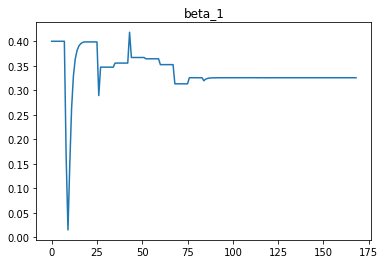

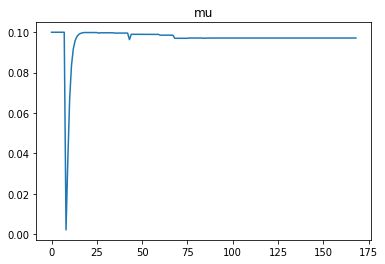

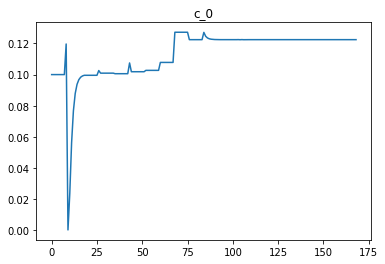

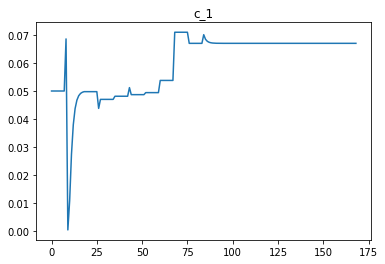

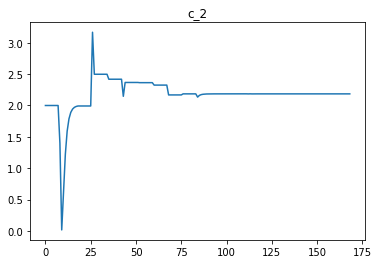

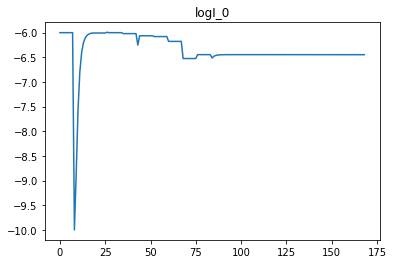

In [194]:
for pp in pars:
    pt = [x[pp].value for x in MyModel.paramall]
    plt.plot(pt)
    plt.title(pp)
    plt.show()

#### slider plot

In [53]:
from IPython.display import display, HTML
from ipywidgets.widgets import interact, interactive, IntSlider, FloatSlider, Layout, ToggleButton, ToggleButtons, fixed
display(HTML("<style>.container { width:100% !important; }</style>"))
style = {'description_width': '100px'}
slider_layout = Layout(width='99%')

In [55]:
params_init_min_max_slider = params_init_min_max.copy()
params_init_min_max_slider = MyModel.transfer_fit_to_params_init(params_init_min_max_slider)

In [56]:
sliderparams = MyModel.allsliderparams(params_init_min_max_slider)
if sliderparams:
    w=interactive(MyModel.slidefitplot,param_class=fixed('ode'),**sliderparams)
    display(w)

interactive(children=(FloatSlider(value=0.5662833921726289, continuous_update=False, description='beta_1', lay…

In [57]:
params_init_min_max_slider = MyModel.transfer_fit_to_params_init(params_init_min_max_slider)

In [58]:
MyModel.prparams()

params:
{'N': 1,
 'alpha': 0.2,
 'beta_1': 0.5662833921726289,
 'beta_2': 0.0,
 'beta_3': 0.0,
 'c_0': 0.256,
 'c_1': 0.087,
 'c_2': 12.61,
 'gamma_1': 0.06999999999999999,
 'gamma_2': 0.16666666666666669,
 'gamma_3': 0.1,
 'mu': 0.125,
 'p_1': 0.030000000000000013,
 'p_2': 0.08333333333333333}
sbparams:
{'CFR': 0.05,
 'DurHosp': 4,
 'DurMildInf': 10,
 'Exposure': 0.4,
 'FracCritical': 0.1,
 'FracMild': 0.7,
 'ICUFrac': 0.001,
 'IncubPeriod': 5,
 'TimeICUDeath': 5,
 'logI_0': -8.44}
pfbarams:
{'FracConfirmedDet': 1.0, 'FracDeathsDet': 1.0}
cbparams:
{'CautionExposure': 0.1,
 'CautionFactor': 0.1,
 'CautionRetention': 60.0,
 'EconomicCostOfCaution': 0.5,
 'EconomicRetention': 60.0,
 'EconomicStriction': 30.0,
 'EconomyRelaxation': 60.0}
dbparams:
{'country': 'Germany', 'data_src': 'owid', 'run_name': 'SC3EI3R'}
initial_values:
(array([9.99999996e-01, 0.00000000e+00, 3.63078055e-09, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+